In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Define paths
base_dir = 'ResNet'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


In [3]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [4]:
# Compute class weights
labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))


In [5]:
# Define model building function
def build_model(learning_rate, dropout_rate):
    input_tensor = Input(shape=(48, 48, 3))
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(7, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [6]:
# Objective function for Bayesian Optimization
def fit_with(learning_rate, dropout_rate):
    model = build_model(learning_rate=10**learning_rate, dropout_rate=dropout_rate)
    history = model.fit(train_generator, 
                        epochs=3, # fewer epochs for optimization speed
                        validation_data=validation_generator,
                        class_weight=class_weights_dict,  
                        verbose=0)
    validation_accuracy = np.amax(history.history['val_accuracy']) 
    return validation_accuracy


In [7]:
# Hyperparameter ranges
params = {
    'learning_rate': (-6, -3),  # log scale
    'dropout_rate': (0.3, 0.7)
}

# Bayesian optimization
optimizer = BayesianOptimization(f=fit_with, pbounds=params, random_state=1)
optimizer.maximize(init_points=10, n_iter=20)

|   iter    |  target   | dropou... | learni... |
-------------------------------------------------


C:\Users\olale\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


| 1         | 0.5344    | 0.4668    | -3.839    |
| 2         | 0.3536    | 0.3       | -5.093    |
| 3         | 0.234     | 0.3587    | -5.723    |
| 4         | 0.3837    | 0.3745    | -4.963    |
| 5         | 0.4845    | 0.4587    | -4.384    |
| 6         | 0.5631    | 0.4677    | -3.944    |
| 7         | 0.4845    | 0.3818    | -3.366    |
| 8         | 0.5386    | 0.311     | -3.989    |
| 9         | 0.5286    | 0.4669    | -4.324    |
| 10        | 0.2979    | 0.3562    | -5.406    |
| 11        | 0.5071    | 0.7       | -4.138    |
| 12        | 0.4603    | 0.7       | -3.0      |
| 13        | 0.5556    | 0.3597    | -4.114    |
| 14        | 0.4586    | 0.3       | -3.0      |
| 15        | 0.5149    | 0.7       | -3.503    |
| 16        | 0.5481    | 0.7       | -3.824    |
| 17        | 0.4951    | 0.5073    | -4.128    |
| 18        | 0.5235    | 0.3       | -4.275    |
| 19        | 0.3892    | 0.7       | -4.752    |
| 20        | 0.4227    | 0.3594    | -4.78     |


In [9]:
# Retrieve the best parameters
best_params = optimizer.max['params']
best_learning_rate = 10 ** best_params['learning_rate']
best_dropout = best_params['dropout_rate']

# Build the final model
model = build_model(learning_rate=best_learning_rate, dropout_rate=best_dropout)

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

# Training the model
model.fit(train_generator,
          epochs=50,
          validation_data=validation_generator,
          class_weight=class_weights_dict,
          callbacks=[checkpoint, early_stopping, reduce_lr],
          verbose=1)


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 785s 836ms/step - accuracy: 0.2626 - loss: 2.0594 - val_accuracy: 0.2608 - val_loss: 1.8975 - learning_rate: 1.1367e-04
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 764s 851ms/step - accuracy: 0.4972 - loss: 1.2691 - val_accuracy: 0.5077 - val_loss: 1.4420 - learning_rate: 1.1367e-04
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 748s 833ms/step - accuracy: 0.5915 - loss: 0.9980 - val_accuracy: 0.5690 - val_loss: 1.1669 - learning_rate: 1.1367e-04
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 739s 823ms/step - accuracy: 0.6576 - loss: 0.8454 - val_accuracy: 0.5829 - val_loss: 1.1466 - learning_rate: 1.1367e-04
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 691s 769ms/step - accuracy: 0.7349 - loss: 0.6621 - val_accuracy: 0.5642 - val_loss: 1.2925 - learning_rate: 1.1367e-04
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 681s 759ms/step - accuracy: 0.8042 - loss: 0.4851 - val_accuracy: 0.5642 - val_loss: 1.3463 - learning_rate: 1.1367e-04
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
# Load the best model
loaded_model = tf.keras.models.load_model('best_model.keras')
print("Model loaded successfully.")

Model loaded successfully.


In [11]:
# Model evaluation on the test data
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


  1/113 ━━━━━━━━━━━━━━━━━━━━ 5:59 3s/step - accuracy: 0.4688 - loss: 4.0066

C:\Users\olale\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 248ms/step - accuracy: 0.5901 - loss: 2.5382
Test Loss: 2.1825, Test Accuracy: 0.6291


In [12]:
# Prediction and classification report
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 243ms/step
Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.52      0.54       491
     disgust       0.75      0.71      0.73        55
        fear       0.53      0.48      0.50       528
       happy       0.79      0.82      0.80       879
     neutral       0.56      0.58      0.57       626
         sad       0.49      0.50      0.50       594
    surprise       0.77      0.79      0.78       416

    accuracy                           0.63      3589
   macro avg       0.63      0.63      0.63      3589
weighted avg       0.63      0.63      0.63      3589



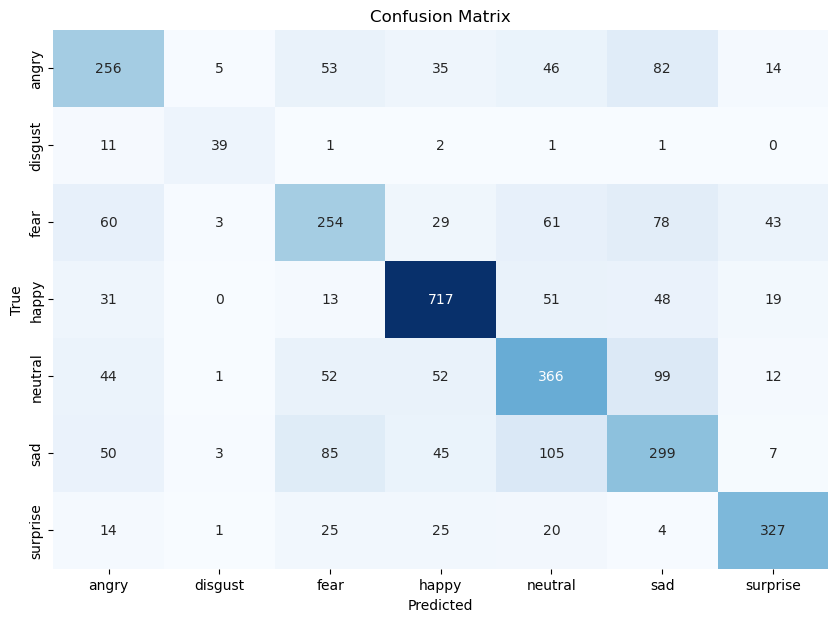

In [13]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()